In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Progetto/kits19/

/content/drive/MyDrive/Progetto/kits19


In [ ]:
#importo un pò di librerie utili
import random
from PIL import Image
import nibabel as nib
import numpy as np
import tensorflow as tf
from skimage.io import imread, imshow
from skimage import data
from skimage.transform import resize
import matplotlib.pyplot as plt


In [ ]:
#Mi salvo i path, per evitare di doverli scrivere ogni volta
DIR_PATH = '/content/drive/MyDrive/Progetto/kits19/data'
IMAGE = '/imaging'
SEGM = '/segmentation'
POSTFIX = '.nii.gz'

#Non avendo a disposizione un account Google Drive con più di 15giga ho dovuto ridurre il dataset a 100 pazienti: 75 per il Training e 25 per il Testing
TRAIN_FROM = 0
TRAIN_TO = 75

TEST_FROM = 75
TEST_TO = 100

In [ ]:
img_path = IMAGE+POSTFIX
#print(img_path)


In [ ]:
#salvo width e height dei valori con cui voglio fare resize dell'immagine
IMG_WIDTH = 256
IMG_HEIGHT = 256 

In [ ]:
def load_size_images(first, last, img_path):
  images = []

  for cases in range(first, last):
    #Carico tutte le foto dalle cartelle
    img = nib.load(DIR_PATH+'/case_'+f'{cases:05d}'+img_path)
    img = img.get_fdata()
    print(cases)

    #Setto le dimensioni di tutto il dataset uguali a quella del caso minimo (paziente 61)
    img = resize(img, (29,IMG_WIDTH, IMG_HEIGHT), order=1, preserve_range=True)

    #Le aggiungo alla lista e le normalizzo
    images = normalize(images, img)

  return images

In [ ]:
#funzione per aggiungere ad una lista delle immagini normalizzate
def normalize(images, img):
  for i in range(0, img.shape[0]):
    images.append(img[i, :, :]/255)

  return images

In [ ]:
#Separo mask e image in due array diversi sia per training che per testing

print('****************************************************')
print('Getting training dataset and loading of the mask')
trainSet = np.array(load_size_images(TRAIN_FROM, TRAIN_TO, IMAGE+POSTFIX))
trainSet_seg = np.array(load_size_images(TRAIN_FROM, TRAIN_TO, SEGM+POSTFIX))
print('Loading of the training set and of the mask done!')
print('****************************************************')

print('****************************************************')
print('Getting testing dataset and loading of the mask')
testSet = np.array(load_size_images(TEST_FROM, TEST_TO, IMAGE+POSTFIX))
testSet_seg = np.array(load_size_images(TEST_FROM, TEST_TO, SEGM+POSTFIX))
print('Loading of the testing set and of the mask done!')
print('****************************************************')

****************************************************
Getting training dataset and loading of the mask
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
Loading of the training set and of the mask done!
****************************************************
****************************************************
Getting testing dataset and loading of the mask
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Loading of the testing set and of the mask done!
****************************************************


In [ ]:
# Binary Segmentation
trainSet_seg[trainSet_seg != 0] = 1

In [ ]:
#Salvo in dei file gli array numpy creati sopra
with open('/content/drive/MyDrive/Progetto/Arrays/IMMAGINI_TRAIN.npy', 'wb') as f:
  np.save(f, trainSet)
with open('/content/drive/MyDrive/Progetto/Arrays/IMMAGINI_TRAIN_LABEL.npy', 'wb') as f:
  np.save(f, trainSet_seg)   
with open('/content/drive/MyDrive/Progetto/Arrays/IMMAGINI_TEST.npy', 'wb') as f:
  np.save(f, testSet)   
with open('/content/drive/MyDrive/Progetto/Arrays/IMMAGINI_TEST_LABEL.npy', 'wb') as f:
  np.save(f, testSet_seg)

In [ ]:
#Carichiamo da file gli array numpy già creati
trainSet = np.load('/content/drive/MyDrive/Progetto/Arrays/IMMAGINI_TRAIN.npy',  mmap_mode='r')
trainSet_seg = np.load('/content/drive/MyDrive/Progetto/Arrays/IMMAGINI_TRAIN_LABEL.npy',  mmap_mode='r')
testSet = np.load('/content/drive/MyDrive/Progetto/Arrays/IMMAGINI_TEST.npy',  mmap_mode='r')
testSet_seg = np.load('/content/drive/MyDrive/Progetto/Arrays/IMMAGINI_TEST_LABEL.npy',  mmap_mode='r')

In [ ]:
#La rete neurale U-NET
def uNet():

    #Contraction path
    # 256x256
    c1 = tf.keras.layers.Conv2D(
        16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', input_shape=(256, 256, 1))(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c1)

    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    # 128x128
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(p1)

    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c2)

    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    # 64x64
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c3)

    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    # 32x32
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c4)

    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    # 16x16
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(
        128, (2, 2), strides=(2, 2), padding='same')(c5)
    # 32x32
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c6)

    # 64x64
    u7 = tf.keras.layers.Conv2DTranspose(
        64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c7)

    # 128x128
    u8 = tf.keras.layers.Conv2DTranspose(
        32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c8)

    # 256x256
    u9 = tf.keras.layers.Conv2DTranspose(
        16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu',
                                kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    return outputs

In [ ]:
#Alleniamo il model con il dataset
print('*********************')
print('Building model...')
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, 1))

outputs = uNet()

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

#Stampiamo tutti i parametri del model       
model.summary()

#Modelcheckpoint per salvare lo stato del modello 
checkpointer = tf.keras.callbacks.ModelCheckpoint('unet_bioimage.h5', verbose=1, save_best_only=True)

# 'EarlyStopping' interrompo il training se val_loss non migliora
# 'TensorBoard' ci da informazioni sul training

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir='logs')
    ]

results = model.fit(trainSet, trainSet_seg, validation_split=0.1,
                    batch_size=8, epochs=5, callbacks=callbacks)
print('*********************')

*********************
Building model...
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 16  0           ['conv2d[0][0]']                 
                                )                     

In [ ]:
preds_train = model.predict(trainSet, verbose=1)
preds_test = model.predict(testSet, verbose=1)


preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

23/23 [==============================] - 3s 114ms/step


In [ ]:
def check_model(Originals, Labels, preds):

    ix = random.randint(0, len(preds))
    
    #Carichiamo l'immagine originale, il suo label, e quello che pensiamo sia un tumore
    orig_image = Originals[ix]
    orig_label = Labels[ix]
    pred_label = preds[ix][:, :, 0]

    #Mostriamo le immagini 
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(orig_image)
    axs[0].set_title("Original image")

    axs[1].imshow(orig_label)
    axs[1].set_title("Original label")

    axs[2].imshow(pred_label)
    axs[2].set_title("Predicted label")

    plt.show()

*******************
Training check: 


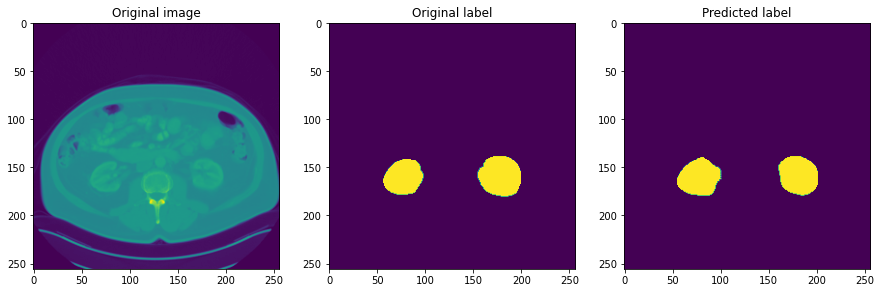

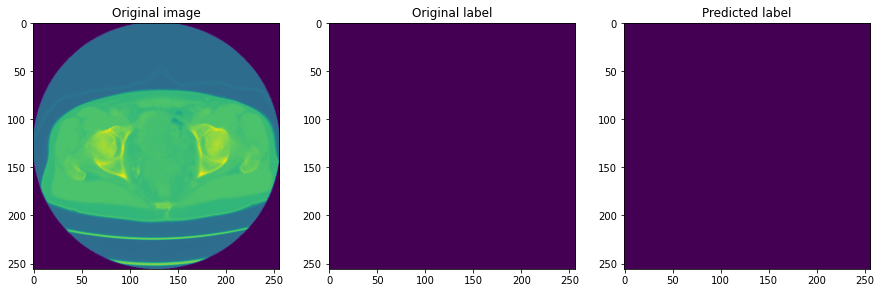

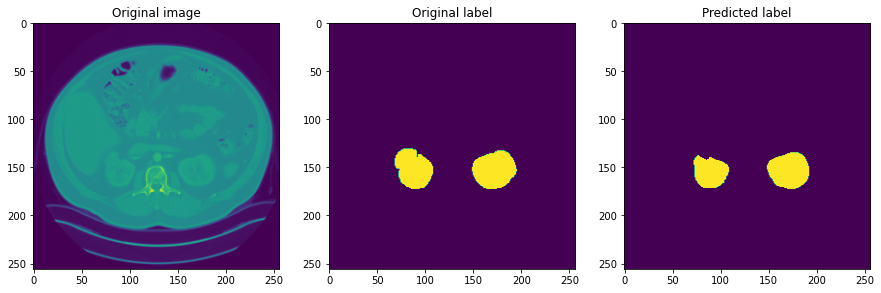

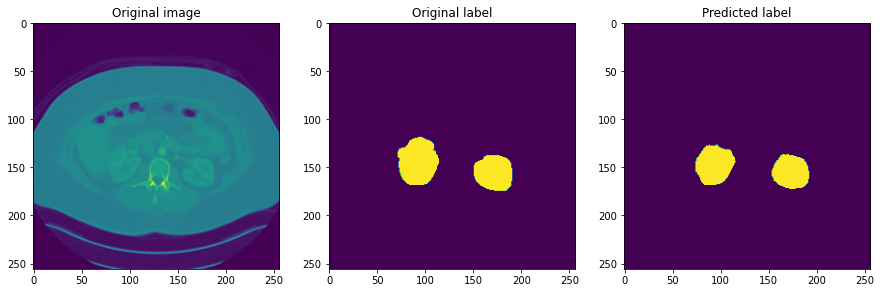

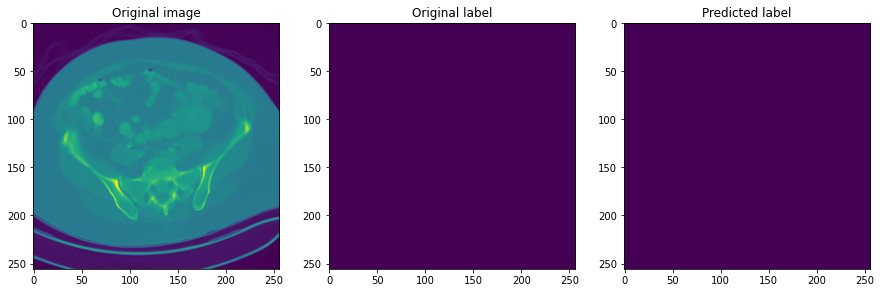

*******************
 
 
*******************
Testing check: 


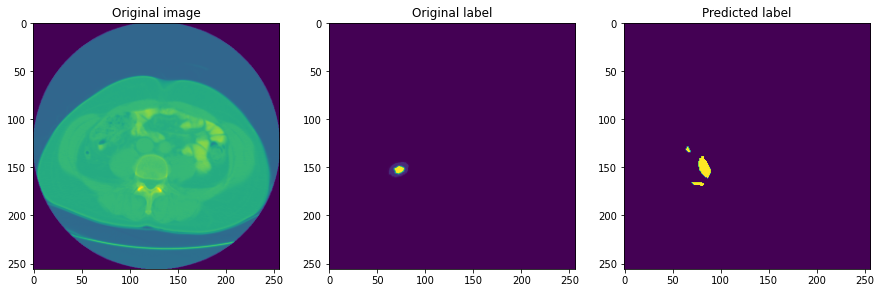

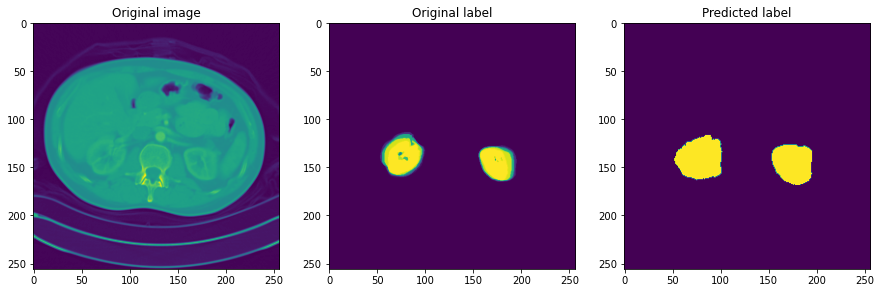

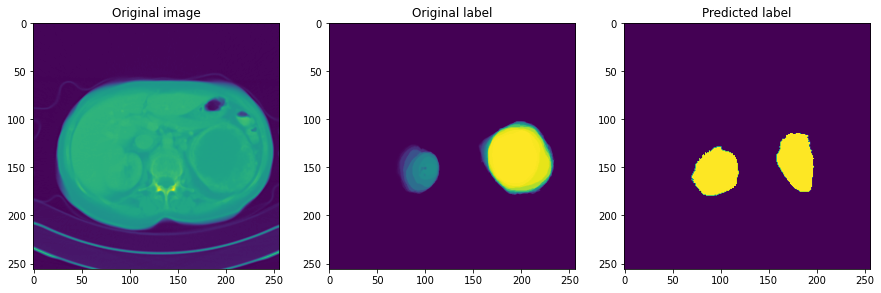

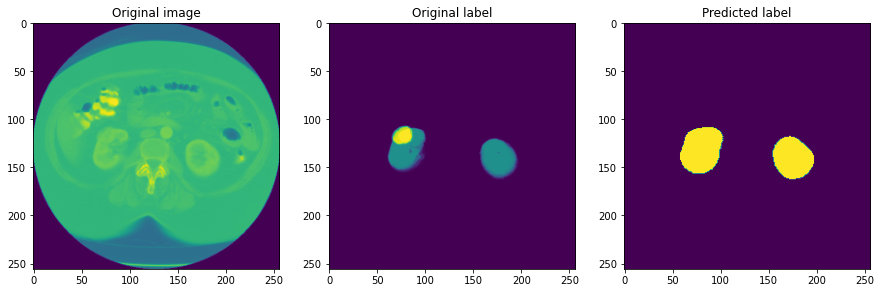

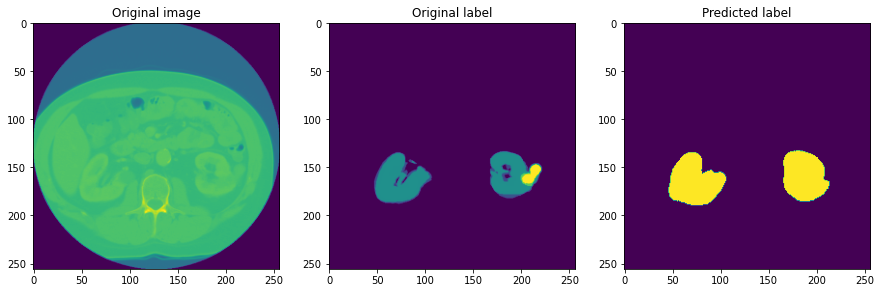

*******************


In [ ]:
# Controlliano se tutto funziona lato training
print('*******************')
print('Training check: ')
for i in range(5):
  check_model(trainSet, trainSet_seg, preds_train_t)
print('*******************')
print(' ')
print(' ')
# Controlliano se tutto funziona lato testing
print('*******************')
print('Testing check: ')
for i in range(5):
  check_model(testSet, testSet_seg, preds_test_t)
print('*******************')